In [1]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.4 MB/s eta 0:00:00


In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv("diabetes.csv")

In [8]:
##Redundant Features
cols = ['id', 'encounter_id', 'patient_nbr','payer_code', 'admission_type_id','discharge_disposition_id','admission_source_id']
data[cols]

,id,encounter_id,patient_nbr,payer_code,admission_type_id,discharge_disposition_id,admission_source_id
0,1,2278392,8222157,?,6,25,1
1,2,149190,55629189,?,1,1,7
2,3,64410,86047875,?,1,1,7
3,4,500364,82442376,?,1,1,7
4,5,16680,42519267,?,1,1,7
...,...,...,...,...,...,...,...
101761,101762,443847548,100162476,MC,1,3,7
101762,101763,443847782,74694222,MC,1,4,5
101763,101764,443854148,41088789,MC,1,1,7
101764,101765,443857166,31693671,MC,2,3,7


In [9]:
data = data.drop(columns = cols)

In [10]:
data.describe(include=["object", "bool"])

,race,gender,age,weight,medical_specialty,diag_1,diag_2,diag_3,max_glu_serum,A1Cresult,...,citoglipton,insulin,glyburide.metformin,glipizide.metformin,glimepiride.pioglitazone,metformin.rosiglitazone,metformin.pioglitazone,change,diabetesMed,readmitted
count,101766,101766,101766,101766,101766,101766,101766,101766,5346,17018,...,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766
unique,6,3,10,10,73,717,749,790,3,3,...,1,4,4,2,2,2,2,2,2,3
top,Caucasian,Female,[70-80),?,?,428,276,250,Norm,>8,...,No,No,No,No,No,No,No,No,Yes,NO
freq,76099,54708,26068,98569,49949,6862,6752,11555,2597,8216,...,101766,47383,101060,101753,101765,101764,101765,54755,78363,54864


In [12]:
ageDict = {'[0-10)' : 5,
'[10-20)' : 15,
'[20-30)' : 25,
'[30-40)' : 35,
'[40-50)' : 45,
'[50-60)' : 55,
'[60-70)' : 65,
'[70-80)' : 75,
'[80-90)' : 85,
'[90-100)' : 95}

data['age'] = data['age'].apply(lambda x : ageDict[x])

In [13]:
data['readmitted'] = data['readmitted'].apply(lambda x : 0 if (x == '>30' or x == 'NO') else 1)

In [14]:
data['health_index'] = data.apply(lambda x:  1 / (x['number_emergency'] + x['number_inpatient'] + x['number_outpatient'])
                                  if x['number_emergency'] != 0 or x['number_inpatient'] != 0 or x['number_outpatient'] != 0
                                  else 1, axis = 1)



total = data['time_in_hospital'].sum() + data['num_procedures'].sum() + data['num_medications'].sum()+\
                                data['num_lab_procedures'].sum() + data['number_diagnoses'].sum()

data['severity_of_disease'] = (data['time_in_hospital'] + data['num_procedures'] +
                              data['num_medications'] + data['num_lab_procedures'] +
                              data['number_diagnoses']) / total

drugList = ['metformin','repaglinide','nateglinide','chlorpropamide','glimepiride','acetohexamide',
            'glipizide','glyburide','tolbutamide','pioglitazone','rosiglitazone','acarbose','miglitol',
            'troglitazone','tolazamide','examide','citoglipton','insulin','glyburide.metformin','glipizide.metformin',
            'glimepiride.pioglitazone','metformin.rosiglitazone','metformin.pioglitazone']


number_of_changes = []
for i in range(len(data)):
    changeCount = 0
    for col in drugList :
        if data.iloc[i][col] in ['Down', 'Up'] :
            changeCount += 1
    number_of_changes.append(changeCount)

data['number_of_changes'] = number_of_changes

In [15]:
data['max_glu_serum'] = data['max_glu_serum'].apply(lambda x : 200 if x == '>200' else ( 300 if x == '>300' else ( 100 if x == 'Norm' else  0)))

In [16]:
data['A1Cresult'] = data['A1Cresult'].apply(lambda x : 7 if x == '>7' else (8 if  x == '>8' else ( 5 if x == 'Norm' else  0)))

In [17]:
for col in drugList:
    data[col] = data[col].apply(lambda x : 10 if x == 'Up' else ( -10 if x == 'Down' else ( 0 if x == 'Steady' else  -20)))


data['change'] = data['change'].apply(lambda x : 1 if x == 'Ch' else -1)

In [18]:
## Engineered Features from domain knowledge
data['total_procedures'] = data['num_procedures'] + data['num_lab_procedures']
data['total_medical_interactions'] = data['number_outpatient'] + data['number_emergency'] + data['number_inpatient']
data['medication_ratio'] = data['num_medications'] / data['time_in_hospital']
data['avg_procedures_per_visit'] = data['total_procedures'] / (data['number_outpatient'] + data['number_inpatient'])
data['diagnoses_per_procedure'] = data['number_diagnoses'] / data['total_procedures']

data["time_in_hospital_per_procedure"] = data["time_in_hospital"] / data["num_procedures"]
data["number_medications_per_diagnosis"] = data["num_medications"] / data["number_diagnoses"]
data["average_lab_procedure_cost"] = data["num_lab_procedures"].mean()
data["emergency_room_visit_rate"] = data["number_emergency"] / data.shape[0]
data["inpatient_admission_rate"] = data["number_inpatient"] / data.shape[0]

In [19]:
data_checkpoint = data.copy()     ### storing the data to avoid redoing things again and again

In [20]:
non_numeric_columns = data.select_dtypes(exclude=[float, int])
data["weight"]  = ["UNK" if str(i) == str(np.nan) else i for i in data["weight"] ]
data.weight.value_counts()

weight
?            98569
[75-100)      1336
[50-75)        897
[100-125)      625
[125-150)      145
[25-50)         97
[0-25)          48
[150-175)       35
[175-200)       11
>200             3
Name: count, dtype: int64

In [21]:
weightDict = {'[50-75)' : '62',
'[75-100)' : '87',
'[100-125)' : '112',
'[125-150)' : '137',
'[25-50)' : '37',
'[0-25)' : '12',
'[150-175)' : '162',
'[175-200)' : '187',
'>200' : '200',
'UNK' : f"{np.nan}",
'?' : f"{np.nan}"}

data['weight'] = data['weight'].apply(lambda x : weightDict[x])

In [22]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

In [23]:
df_with_dummies = pd.get_dummies(data, drop_first=True)

In [25]:
for column in data.columns:
    if data[column].dtype == 'object':
        data[column] = label_encoder.fit_transform(data[column])

In [26]:
data

,race,gender,age,weight,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,...,total_procedures,total_medical_interactions,medication_ratio,avg_procedures_per_visit,diagnoses_per_procedure,time_in_hospital_per_procedure,number_medications_per_diagnosis,average_lab_procedure_cost,emergency_room_visit_rate,inpatient_admission_rate
0,3,0,5,9,1,38,41,0,1,0,...,41,0,1.000000,inf,0.024390,inf,1.000000,43.095641,0.0,0.00000
1,3,0,15,9,3,0,59,0,18,0,...,59,0,6.000000,inf,0.152542,inf,2.000000,43.095641,0.0,0.00000
2,1,0,25,9,2,0,11,5,13,2,...,16,3,6.500000,5.333333,0.375000,0.400000,2.166667,43.095641,0.0,0.00001
3,3,1,35,9,2,0,44,1,16,0,...,45,0,8.000000,inf,0.155556,2.000000,2.285714,43.095641,0.0,0.00000
4,3,1,45,9,1,0,51,0,8,0,...,51,0,8.000000,inf,0.098039,inf,1.600000,43.095641,0.0,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,1,1,75,9,3,0,51,0,16,0,...,51,0,5.333333,inf,0.176471,inf,1.777778,43.095641,0.0,0.00000
101762,1,0,85,9,5,0,33,3,18,0,...,36,1,3.600000,36.000000,0.250000,1.666667,2.000000,43.095641,0.0,0.00001
101763,3,1,75,9,1,0,53,0,9,1,...,53,1,9.000000,53.000000,0.245283,inf,0.692308,43.095641,0.0,0.00000
101764,3,0,85,9,10,63,45,2,21,0,...,47,1,2.100000,47.000000,0.191489,5.000000,2.333333,43.095641,0.0,0.00001


In [27]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split
import time
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier, ExtraTreesClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from tabulate import tabulate
from tqdm import tqdm

In [28]:
data = data.replace([np.inf, -np.inf], 0)

In [29]:
import time
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score
import numpy as np
from tqdm import tqdm
import pandas as pd
from tabulate import tabulate

def BasedLine(df, method, models, n_splits=10):
    start_time = time.time()  # Record the start time

    df_check = df.copy()

    y = df_check['readmitted']
    X = df_check.drop(columns='readmitted')

    #X = X.fillna(0)
    X = X.fillna(X.mean())

    stratified_kfold = StratifiedKFold(n_splits=n_splits, random_state=2023, shuffle=True)

    scoring = 'accuracy'
    results, results_weigh = [], []
    names = []
    scores, scores_weigh = [], []
    auc_scores = []  # Store AUC scores
    data = []
    for name, model in models:
        model_scores = []
        model_scores_weigh = []
        model_auc_scores = []  # Store AUC scores for each fold

        with tqdm(total=n_splits, desc=f"Running {name}") as pbar:
            for train_idx, test_idx in stratified_kfold.split(X, y):
                X_train, X_valid = X.iloc[train_idx], X.iloc[test_idx]
                y_train, y_valid = y.iloc[train_idx], y.iloc[test_idx]

                model.fit(X_train, y_train)
                score_non = f1_score(model.predict(X_valid), y_valid)
                score_weigh = f1_score(model.predict(X_valid), y_valid, average='weighted')
                model_scores.append(score_non)
                model_scores_weigh.append(score_weigh)

                # Calculate AUC score
                proba = model.predict_proba(X_valid)[:, 1]
                auc = roc_auc_score(y_valid, proba)
                model_auc_scores.append(auc)

                pbar.update(1)

        names.append(name)
        scores_weigh.append(model_scores_weigh)
        auc_scores.append(model_auc_scores)  # Store AUC scores for the model

        # Calculate mean AUC score across folds
        mean_auc = np.mean(model_auc_scores)

        data.append([name, np.mean(model_scores), np.mean(model_scores_weigh), mean_auc])

    headers = ["Model", "F1 Score", "F1 Score Weighted", "AUC Score"]
    print(tabulate(data, headers=headers, tablefmt='orgtbl'))

    end_time = time.time()  # Record the end time
    execution_time = end_time - start_time
    print("Execution time: {:.2f} seconds".format(execution_time))

    df_results = pd.DataFrame(data, columns=headers)
    return df_results


In [30]:
def BasedModel():
    basedModels = []
    basedModels.append(('LR'   , LogisticRegression()))
    basedModels.append(('RF'   , RandomForestClassifier()))
    basedModels.append(('GBM'  , GradientBoostingClassifier()))
    basedModels.append(('ET'   , ExtraTreesClassifier()))
    basedModels.append(('XG'   , XGBClassifier()))
    basedModels.append(('LG'   , LGBMClassifier()))
    basedModels.append(('CAT'   , CatBoostClassifier(silent=True)))
    return basedModels

In [31]:
models = BasedModel()

In [32]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [33]:
#result
result = BasedLine(df = data, method = False , models = models, n_splits=10)

Running LR:   0%|                                                                               | 0/10 [00:00<?, ?it/s]C:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
Running LR:  10%|███████                                                                | 1/10 [00:03<00:27,  3.04s/it]C:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Incre

[LightGBM] [Info] Number of positive: 10221, number of negative: 81368
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027729 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2559
[LightGBM] [Info] Number of data points in the train set: 91589, number of used features: 47
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111596 -> initscore=-2.074538
[LightGBM] [Info] Start training from score -2.074538


Running LG:  10%|███████                                                                | 1/10 [00:03<00:28,  3.16s/it]

[LightGBM] [Info] Number of positive: 10221, number of negative: 81368
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055905 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2555
[LightGBM] [Info] Number of data points in the train set: 91589, number of used features: 47
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111596 -> initscore=-2.074538
[LightGBM] [Info] Start training from score -2.074538


Running LG:  20%|██████████████▏                                                        | 2/10 [00:05<00:22,  2.84s/it]

[LightGBM] [Info] Number of positive: 10221, number of negative: 81368
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026635 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2552
[LightGBM] [Info] Number of data points in the train set: 91589, number of used features: 47
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111596 -> initscore=-2.074538
[LightGBM] [Info] Start training from score -2.074538


Running LG:  30%|█████████████████████▎                                                 | 3/10 [00:08<00:17,  2.56s/it]

[LightGBM] [Info] Number of positive: 10221, number of negative: 81368
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025616 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2559
[LightGBM] [Info] Number of data points in the train set: 91589, number of used features: 47
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111596 -> initscore=-2.074538
[LightGBM] [Info] Start training from score -2.074538


Running LG:  40%|████████████████████████████▍                                          | 4/10 [00:09<00:13,  2.32s/it]

[LightGBM] [Info] Number of positive: 10221, number of negative: 81368
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052222 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 91589, number of used features: 47
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111596 -> initscore=-2.074538
[LightGBM] [Info] Start training from score -2.074538


Running LG:  50%|███████████████████████████████████▌                                   | 5/10 [00:12<00:11,  2.25s/it]

[LightGBM] [Info] Number of positive: 10221, number of negative: 81368
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025031 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2546
[LightGBM] [Info] Number of data points in the train set: 91589, number of used features: 46
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111596 -> initscore=-2.074538
[LightGBM] [Info] Start training from score -2.074538


Running LG:  60%|██████████████████████████████████████████▌                            | 6/10 [00:13<00:08,  2.13s/it]

[LightGBM] [Info] Number of positive: 10222, number of negative: 81368
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034229 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2549
[LightGBM] [Info] Number of data points in the train set: 91590, number of used features: 47
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111606 -> initscore=-2.074440
[LightGBM] [Info] Start training from score -2.074440


Running LG:  70%|█████████████████████████████████████████████████▋                     | 7/10 [00:15<00:06,  2.04s/it]

[LightGBM] [Info] Number of positive: 10222, number of negative: 81368
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026457 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2553
[LightGBM] [Info] Number of data points in the train set: 91590, number of used features: 47
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111606 -> initscore=-2.074440
[LightGBM] [Info] Start training from score -2.074440


Running LG:  80%|████████████████████████████████████████████████████████▊              | 8/10 [00:17<00:04,  2.01s/it]

[LightGBM] [Info] Number of positive: 10222, number of negative: 81368
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033688 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2553
[LightGBM] [Info] Number of data points in the train set: 91590, number of used features: 47
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111606 -> initscore=-2.074440
[LightGBM] [Info] Start training from score -2.074440


Running LG:  90%|███████████████████████████████████████████████████████████████▉       | 9/10 [00:19<00:01,  2.00s/it]

[LightGBM] [Info] Number of positive: 10221, number of negative: 81369
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025763 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2565
[LightGBM] [Info] Number of data points in the train set: 91590, number of used features: 47
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111595 -> initscore=-2.074550
[LightGBM] [Info] Start training from score -2.074550


Running CAT: 100%|█████████████████████████████████████████████████████████████████████| 10/10 [07:50<00:00, 47.09s/it]

| Model   |   F1 Score |   F1 Score Weighted |   AUC Score |
|---------+------------+---------------------+-------------|
| LR      |  0.012638  |            0.939031 |    0.626503 |
| RF      |  0.0242708 |            0.938596 |    0.61187  |
| GBM     |  0.0210413 |            0.938798 |    0.647787 |
| ET      |  0.0230387 |            0.938435 |    0.606738 |
| XG      |  0.0339175 |            0.935105 |    0.63189  |
| LG      |  0.020011  |            0.938792 |    0.647903 |
| CAT     |  0.0293254 |            0.937459 |    0.645921 |
Execution time: 2348.98 seconds


In [34]:
result

,Model,F1 Score,F1 Score Weighted,AUC Score
0,LR,0.012638,0.939031,0.626503
1,RF,0.024271,0.938596,0.611870
2,GBM,0.021041,0.938798,0.647787
3,ET,0.023039,0.938435,0.606738
4,XG,0.033918,0.935105,0.631890
5,LG,0.020011,0.938792,0.647903
6,CAT,0.029325,0.937459,0.645921


In [35]:
import matplotlib.pyplot as plt
import seaborn as sns  # Import seaborn for color palettes

def plot_bar_and_histogram(dataframe):
    plt.figure(figsize=(15, 5))

    # Define a color palette with the number of unique models in the DataFrame
    num_models = len(dataframe['Model'])
    colors = sns.color_palette('husl', n_colors=num_models)

    # Bar plot for F1 Score
    ax1 = plt.subplot(1, 3, 1)
    bars = plt.bar(dataframe['Model'], dataframe['F1 Score'], color=colors)
    plt.xlabel('Model')
    plt.ylabel('F1 Score')
    plt.title('Plot of F1 Score')

    # Add text annotations to the bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 3), ha='center', va='bottom')

    # Bar plot for F1 Score Weighted
    plt.subplot(1, 3, 2)
    barss = plt.bar(dataframe['Model'], dataframe['F1 Score Weighted'], color=colors)
    plt.xlabel('Model')
    plt.ylabel('F1 Score Weighted')
    plt.title('Plot of F1 Score Weighted')

    # Add text annotations to the bars
    for bar in barss:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 3), ha='center', va='bottom')
        
    # Bar plot for AUC Score
    plt.subplot(1, 3, 3)
    barss = plt.bar(dataframe['Model'], dataframe['AUC Score'], color=colors)
    plt.xlabel('Model')
    plt.ylabel('AUC Score')
    plt.title('Plot of AUC Score')

    # Add text annotations to the bars
    for bar in barss:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 3), ha='center', va='bottom')

    plt.tight_layout()
    plt.show()


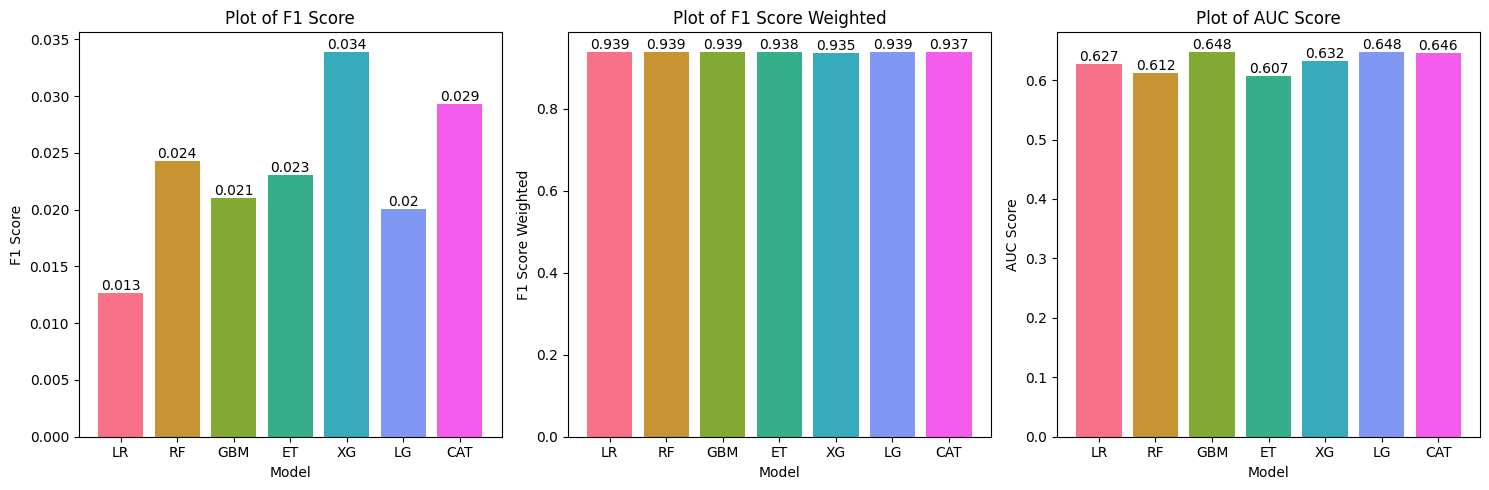

In [36]:
plot_bar_and_histogram(dataframe = result)